In [1]:
import os
import logging
import cv2 as cv
import csv
import pandas as pd
import gc

import torch
import numpy as np
from tqdm import tqdm
from PIL import Image
from torchvision import transforms

from utils.utils import draw_grad_cam, draw_roc, draw_confusion_matrix, std_mpl, ApplyCLAHE, show_transformed_images, mask2image, get_cam_metrics
from models.seg.UNet.unet_model import UNet, R2UNet
from utils.plot import plot_img_and_mask, std_mpl
from predict_utils import predict_mask, predict_to_mask
from utils.image2json import remap_mask_classes
import matplotlib.pyplot as plt

std_mpl()

In [2]:
# setting
model_name = 'UNet'
load_path = '../train/train_save/checkpoints/HAM/UNet/2024-02-21/12/best.pth'
input_path = 'E:/Datas/work/HairEffect/RawData/HAM10000/HAM_Test/NoHair/Image'
masks_path = 'E:/Datas/work/HairEffect/RawData/HAM10000/HAM_Test/NoHair/Mask'
output_path = f'./output/HAM/{model_name}/Test/NoHair'
predict_threshold = 0.5
size = (256, 256)
num_classes = 2 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

predict_path = f'{output_path}/predict'
cam_path = f'{output_path}/cam'
indicators_path = f'{output_path}/indicators.csv'

os.makedirs(predict_path, exist_ok=True)
os.makedirs(cam_path, exist_ok=True)

indicators_header = ['image_name', 'iou', 'dice', 'distance']
with open(indicators_path, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(indicators_header)
    

In [3]:
if model_name.upper() == "UNET":
    model = UNet(n_channels=3, n_classes=num_classes)
    last_layer = model.up4
model.to(device=device)
state_dict = torch.load(load_path, map_location=device)
mask_values = state_dict.pop('mask_values', [0, 255])
model.load_state_dict(state_dict)
logging.info('Model loaded!')

INFO:root:Model loaded!


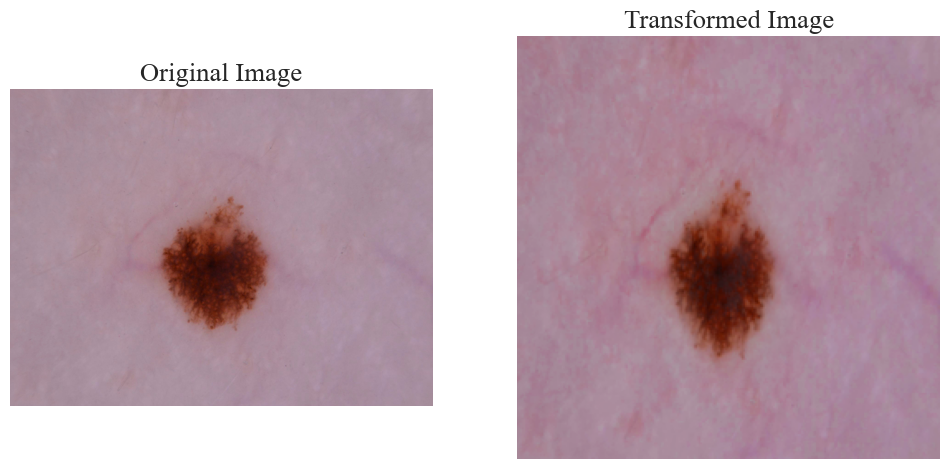

In [4]:
# image setting
images_path = os.listdir(input_path)

transform = transforms.Compose([
    transforms.Resize(size),
    ApplyCLAHE(channel='HSV', enhance=1),
    transforms.ToTensor(),
])

show_transformed_images(f'E:/Datas/work/HairEffect/RawData/HAM10000/HAM_Test/NoHair/Image/ISIC_0024352.jpg', transform)


In [5]:
# predict looping
all_true, all_proba, all_predict = [], [], []
sample_indices = []
count, max_samples = 0, 100

for image_path in tqdm(images_path):
    full_image_path = f"{input_path}/{image_path}"
    image_name = image_path.split('.')[0]
    out_image_path = f'{predict_path}/{image_path}'
    
    image = Image.open(full_image_path)
    transformed_image = transforms.ToPILImage()(transform(image))
    
    predict, proba = predict_mask(
        model=model,
        image=transformed_image,
        size=size,
        threshold=predict_threshold,
        device=device
    )
    result = predict_to_mask(predict=predict, mask_values=mask_values)
    result.save(out_image_path)
    
    if masks_path is not None:
        plots_path = f'{output_path}/plots'
        os.makedirs(plots_path, exist_ok=True)
        
        full_mask_path = f'{masks_path}/{image_path}'
        true_mask = np.copy(np.asarray(Image.open(full_mask_path).convert('L'))) # turn to grayscale 
        true_mask_resize = cv.resize(true_mask, size)
        true_mask_remap = remap_mask_classes(true_mask_resize, mask_values)
        true_mask_normal = true_mask_remap / 255.
        
        plot_img_and_mask(image=transformed_image, predict_mask=result, true_mask=true_mask_remap, colors=[[255, 255, 0]], save_path=f'{plots_path}/{image_path}')
        
        iou, dice, distance = get_cam_metrics(model=model, target_layers=[last_layer], cuda=True, pil_image=transformed_image, target_category=1, true_mask=true_mask_normal)
        
        indicators_row = [image_name, iou, dice, distance]
        with open(indicators_path, mode='a', newline='') as file:
            writer = csv.writer(file)
            writer.writerow(indicators_row)
        
        if count < max_samples:
            all_true.extend(true_mask_normal.flatten())
            all_proba.extend(proba[1].flatten())
            all_predict.extend(predict[1].flatten())
            count += 1

    draw_grad_cam(model=model, target_layers=[last_layer], cuda=True, pil_image=transformed_image, target_category=1, save_path=f'{cam_path}/{image_path}')

  0%|          | 0/1592 [00:00<?, ?it/s]INFO:root:Save plot
INFO:root:Save Cam
  0%|          | 1/1592 [00:02<1:16:21,  2.88s/it]INFO:root:Save plot
INFO:root:Save Cam
  0%|          | 2/1592 [00:03<44:59,  1.70s/it]  INFO:root:Save plot
INFO:root:Save Cam
  0%|          | 3/1592 [00:04<36:04,  1.36s/it]INFO:root:Save plot
INFO:root:Save Cam
  0%|          | 4/1592 [00:05<30:28,  1.15s/it]INFO:root:Save plot
INFO:root:Save Cam
  0%|          | 5/1592 [00:06<27:43,  1.05s/it]INFO:root:Save plot
INFO:root:Save Cam
  0%|          | 6/1592 [00:07<27:01,  1.02s/it]INFO:root:Save plot
INFO:root:Save Cam
  0%|          | 7/1592 [00:08<26:02,  1.01it/s]INFO:root:Save plot
INFO:root:Save Cam
  1%|          | 8/1592 [00:09<26:20,  1.00it/s]INFO:root:Save plot
INFO:root:Save Cam
  1%|          | 9/1592 [00:10<26:24,  1.00s/it]INFO:root:Save plot
INFO:root:Save Cam
  1%|          | 10/1592 [00:11<25:43,  1.03it/s]INFO:root:Save plot
INFO:root:Save Cam
  1%|          | 11/1592 [00:12<25:26,  1.04it

In [6]:
draw_roc(np.array(all_true), np.array(all_proba), title='ROC', class_labels=['few']) 
plt.savefig(f'{output_path}/ROC.jpg')
plt.close()

In [7]:
draw_confusion_matrix(all_true, all_predict, display_labels=['disease', 'background'])
plt.savefig(f'{output_path}/CM.jpg')
plt.close()

del all_true, all_proba
gc.collect()

26439659

In [8]:
# mask to image
mask2image_save_path = f"{output_path}/mask2image"
os.makedirs(mask2image_save_path, exist_ok=True)
masks_path = os.listdir(predict_path) 

for mask_path in tqdm(masks_path):
    full_mask_path = f"{predict_path}/{mask_path}"
    full_image_path = f"{input_path}/{mask_path}"
    full_mask2image_save_path = f"{mask2image_save_path}/{mask_path}"
    mask2image(full_mask_path, full_image_path, full_mask2image_save_path, size)

100%|██████████| 1592/1592 [00:20<00:00, 77.12it/s]


In [9]:
# show mask and image
import cv2 as cv
import matplotlib.pyplot as plt
import gc

mask2image_save_path = f"{output_path}/mask2image"
os.makedirs(mask2image_save_path, exist_ok=True)
masks_path = os.listdir(predict_path) 
check_path = f"{output_path}/check"
os.makedirs(check_path, exist_ok=True)

for mask_path in tqdm(masks_path):
    full_mask_path = f"{mask2image_save_path}/{mask_path}"
    full_image_path = f"{input_path}/{mask_path}"
    
    image = cv.imread(full_image_path)
    mask = cv.imread(full_mask_path)
    image_rgb = cv.cvtColor(image, cv.COLOR_BGR2RGB)
    mask_rgb = cv.cvtColor(mask, cv.COLOR_BGR2RGB)
    
    # Display the original image
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
    plt.imshow(image_rgb)
    plt.title('Original Image')
    plt.axis('off')  # Hide axis

    # Display the processed image
    plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
    plt.imshow(mask_rgb)
    plt.title('Processed Image')
    plt.axis('off')  # Hide axis
    plt.savefig(f'{check_path}/{mask_path}')
    plt.clf()
    plt.close()
    del image, mask, image_rgb, mask_rgb
    gc.collect()

100%|██████████| 1592/1592 [09:29<00:00,  2.79it/s]


In [10]:
# Draw box plots for indicators
import pandas as pd
import seaborn as sns

no_hair_path = './output/HAM/UNet/Test/NoHair/indicators.csv'
few_hair_path = './output/HAM/UNet/Test/WithHair/few/indicators.csv'
many_hair_path = './output/HAM/UNet/Test/WithHair/many/indicators.csv'

df1 = pd.read_csv(no_hair_path)
df2 = pd.read_csv(few_hair_path)
df3 = pd.read_csv(many_hair_path)

# normalize distance
for df in [df1, df2, df3]:
    min_distance = df['distance'].min()
    max_distance = df['distance'].max()
    df['distance'] = (df['distance'] - min_distance) / (max_distance - min_distance)

df1['Condition'] = 'no'
df2['Condition'] = 'few'
df3['Condition'] = 'many'

df_combined = pd.concat([df1, df2, df3])
df_melted = df_combined.melt(id_vars='Condition', value_vars=['iou', 'dice', 'distance'], var_name='Metric', value_name='Value')

fig, ax = plt.subplots(dpi=2000, figsize=(14, 8))
sns.boxplot(x='Metric', y='Value', hue='Condition', data=df_melted, palette=['#ff7f0e', '#da5bac', '#1f77b4'], ax=ax)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.ylabel('Metric Value')
legend = ax.legend(loc='upper right',bbox_to_anchor=(1.1, 1), frameon=False)
plt.savefig('metric_comparison.jpg')
plt.close('all')

E:\CondaEvens\PyTorch\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
E:\CondaEvens\PyTorch\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
E:\CondaEvens\PyTorch\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
E:\CondaEvens\PyTorch\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dty